# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

<img src='rnn_img/one_hot_encoding.png' width=50%>

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='rnn_img/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='rnn_img/tokenize_lookup.png' width=50%>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="rnn_img/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="rnn_img/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="rnn_img/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
with open('data/text8') as f: # Load text sample
    text = f.read()
    
print(text[:300]) # Print first 300 characters

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organiz


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

words = utils.preprocess(text) #get list of words
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
#print some stats
print('Number of Words;', len(words))
print('Unqiue Words:' , len(set(words)))

Number of Words; 16680599
Unqiue Words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
from collections import Counter

word_counts = Counter(words) # Counter data type creates a dictionary w/ each word being a key 
                            # and the value as the number of occurences.

# sorting the words from most to least frequent in text occurrence
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print(sorted_vocab[:10]) # most common ten lines

# create int_to_vocab dictionaries
int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

int_words = [vocab_to_int[word] for word in words] # Look up indexes

['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two']


In [5]:
print(int_words[:30]) # First thirty words converted to indexes

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
# Store indexes
import numpy as np
import random

threshold = 1e-5
word_counts = Counter(int_words)
num_of_words = len(int_words)

# Calculate the frequency percentage of each word
freq_of_ea_word = {word: freq/num_of_words for word, freq in word_counts.items()}
# Calculate Propability to drop
p_drop = {word: 1 - np.sqrt(threshold/freq_of_ea_word[word]) for word in word_counts }

#Drop Rate of 'The'
print('Probability of the dropout for the word: the:', p_drop[vocab_to_int['the']])

# Filter by chance - generate a random value to determine if word is dropped
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
print(train_words[:30])
                            

Probability of the dropout for the word: the: 0.9874637657774047
[5233, 3080, 10571, 133, 27349, 15067, 58112, 3580, 190, 10712, 454, 3672, 708, 53, 97, 1423, 686, 7088, 5233, 27, 44611, 2877, 5233, 200, 1134, 2621, 8983, 4147, 6437, 4186]


# Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
 
    Range = np.random.randint(1, window_size+1)
    start = idx - Range if (idx - Range) > 0 else 0
    stop = idx + Range
    # word[Inclusive: Excluded]
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [8]:
test = [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
target_words = get_target(test, 2)
print(target_words)

[5233, 58, 10571, 27349, 0, 15067]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [9]:
def get_batches(words, batch_size, window_size = 5):
    
    n_batches = len(words)//batch_size # Divide into batches
    words = words[:n_batches*batch_size] # Only full batches
    
    # Seperate Input from Target Data Output
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [10]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 2]


## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="rnn_img/skip_gram_net_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [11]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

In [12]:
import torch
from torch import nn
import torch.optim as optim

In [15]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = 
        self.out_embed = 
        
        # Initialize both embedding tables with uniform distribution
        
    def forward_input(self, input_words):
        # return input vector embeddings

        return None
    
    def forward_output(self, output_words):
        # return output vector embeddings

        return None
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        ## TODO: get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)

        
        return None

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [16]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

cuda
which | esti, sighting, surface, imports, hobsbawm
eight | analyzes, courtier, phane, lippisch, artifacts
after | martina, collin, compete, plein, orrin
known | showers, gnosis, czapski, psychosomatic, renown
b | constitutes, promotes, faqs, calibrated, identifiable
can | scent, behave, csp, begin, virginal
but | chalker, sultan, legge, psychiatry, minimum
these | assurance, colle, sicherheitsdienst, guardant, chiang
numerous | mature, neonatal, wfw, prospective, concert
know | everybody, disintegrates, perfumed, compulsory, polar
file | yields, quds, amt, polymers, umm
award | fear, tear, grandest, itt, legionnaire
quite | aap, gott, skybox, wipo, for
experience | vector, bayreuth, kroon, pyre, cs
smith | blood, malcom, washington, shoemaker, reminiscent
behind | pioneered, excessive, recursive, bitola, hee
...
there | partnerships, pcs, gaff, ucayali, verse
or | bhfuil, maggie, stanfield, spurious, radner
united | unranked, rheingold, petersburg, mikl, specialising
american | wy

between | retort, harmonics, were, prospectors, jia
its | sfa, celebritarian, amoeba, triune, forged
american | wynette, kaline, cccc, actinium, risc
if | weren, maximal, denoted, pushkin, unanimity
called | decrees, internship, pentameter, amongst, supplement
i | do, rrez, grundgesetz, hop, acton
of | mad, constitutionalism, gorges, vogler, bertram
some | geomorphology, berries, questioning, baccal, radical
square | locus, publicise, tarquinius, toc, outside
smith | washington, malcom, jair, irritate, enos
mainly | resemble, epicureanism, chinensis, ancient, alcohols
defense | dwells, samantha, rechargeable, partitions, hugo
ice | overstate, saltire, firebird, peachtree, bitterly
notes | dunedin, placeholder, newburgh, vulgar, curfews
assembly | constitution, softwood, exhorted, resigns, anatolian
woman | marino, kindred, cosell, penwith, propraetor
...
about | radioisotope, mercantilism, nagpur, charts, analyzes
into | leucine, tumbling, mitnagdim, glial, eof
he | banshee, maxi, subp

which | abyss, schweickart, scattering, stony, ammonia
see | ithilien, media, campeador, logicians, journals
over | helper, zero, five, amn, illyrian
no | caltrans, ltv, diminished, bradykinin, disintegrates
more | often, ceawlin, basica, danelaw, over
war | battle, forces, armed, wars, jolene
many | microprogram, resurgence, scrip, cryptids, shortcuts
united | unranked, specialising, clandestinely, decolonization, independence
joseph | zoologist, baladan, clu, wanted, malt
except | logistics, prester, bangkok, narrowest, lahore
square | outside, tarquinius, stands, dandelin, in
bill | talkative, ilife, commute, underworld, clift
egypt | judea, fording, marsyas, navajo, llah
numerous | underlined, mature, stamina, leste, expounds
woman | her, claus, nocturnal, melissa, fertility
shown | libido, tonnes, be, touted, bombardier
...
eight | one, seven, three, six, zero
between | arcturus, soddy, jia, mortally, retort
all | seafarers, tiff, mohel, jammu, haggai
it | suiko, just, don, identi

only | not, boundary, be, earmarked, expressly
zero | two, one, five, three, four
after | first, the, was, on, in
this | divisible, the, scriptura, january, bestow
people | african, deaths, activists, births, living
about | zero, embezzlement, estimated, tok, radioisotope
eight | one, six, seven, three, zero
can | examples, be, cannot, must, denominator
egypt | egyptian, judea, ibrahim, arab, mortars
heavy | detonated, nonkinetochore, cleaners, trainspotting, heavier
applications | operating, deployed, computational, offers, unix
brother | parents, father, throne, wife, he
professional | nielsen, mike, alma, cured, guild
shown | be, column, libido, alcindor, rias
creation | the, world, xvi, its, friendships
universe | osiris, fictional, existence, cosmic, spin
...
will | you, if, buy, would, should
new | york, amd, s, also, yankees
zero | two, one, five, three, four
by | and, of, was, led, nine
which | both, having, abyss, soiled, s
people | living, births, deaths, african, activists
b

they | them, themselves, but, their, do
will | you, your, my, if, should
had | was, he, were, his, later
between | both, and, in, varies, boundary
after | first, nagast, shortly, was, november
state | states, maryland, south, united, indiana
states | united, state, america, u, federal
to | a, the, from, through, this
quite | exquisite, seem, western, crawling, speaking
existence | exist, not, universal, philosophy, divine
hit | hits, singles, foul, songs, pop
grand | caroline, colorado, marlborough, catalina, atl
applications | application, computer, computational, software, technologies
lived | restaurant, eldest, decorator, lobos, collapsed
rise | eroded, economic, inspired, resulted, raj
magazine | monthly, newspaper, comics, interview, news
...
may | or, are, occur, some, must
the | of, in, by, a, and
is | or, and, of, an, a
such | or, are, as, based, can
it | that, without, not, but, if
six | five, three, eight, two, four
state | states, maryland, law, energy, civility
have | ther

four | two, one, three, five, six
many | some, generally, these, particularly, often
b | d, writer, composer, one, politician
see | also, external, links, list, history
called | also, the, of, is, single
between | conflict, boundary, ofcom, differences, resolved
who | him, son, father, believe, gods
had | was, were, later, after, they
prince | princess, duke, emperor, queen, son
accepted | whether, cytokinesis, stated, there, inaccurate
animals | animal, species, mammals, insects, humans
proposed | investigate, plan, formulating, agree, experimentally
placed | robes, wooden, upside, rows, intersects
ocean | atlantic, sea, islands, coast, island
smith | david, john, jr, adams, matthew
professional | mike, fame, baseball, players, wrestler
...
can | properties, be, or, example, cannot
when | until, get, mohiam, explodes, charge
it | the, country, to, its, now
were | had, was, by, but, became
his | he, him, father, himself, wrote
five | one, three, six, two, zero
eight | one, six, seven, 

system | systems, operates, peripheral, regulation, control
with | and, in, as, the, of
such | often, as, or, various, combining
on | in, the, and, of, june
by | the, and, of, in, as
a | and, the, in, is, for
known | as, in, the, of, and
world | international, war, united, nation, europe
brother | son, sister, father, him, younger
something | what, you, anything, we, nothing
units | unit, army, newtons, commando, density
paris | de, france, du, des, le
orthodox | churches, orthodoxy, church, christian, christianity
applications | application, server, computer, desktop, unix
scale | scales, notes, tremolo, simpler, intervals
test | tests, testing, match, tested, scoring
...
in | the, and, of, s, also
from | the, and, to, of, in
new | york, and, inc, also, first
will | you, should, your, want, do
as | such, by, a, and, the
i | you, me, my, t, know
not | does, but, do, if, never
between | marriage, neutral, these, conflict, border
pressure | fluid, atmospheric, pressures, heat, flow
ocean

if | any, be, does, then, must
they | do, their, all, them, have
than | more, less, very, low, generally
zero | five, two, three, six, nine
that | not, be, this, have, things
states | united, america, confederacy, confederate, state
about | page, billions, puf, stanford, s
into | another, through, the, off, process
engineering | engineers, sciences, technology, biotechnology, electrical
marriage | married, her, wife, marriages, she
centre | situated, city, shopping, tourist, medi
test | tests, testing, level, ozone, match
resources | arable, free, resource, includes, portal
universe | cosmic, fictional, marvel, bang, dark
professional | junior, wrestler, championships, football, training
operating | os, kernel, windows, unix, disk
...
there | have, no, are, all, these
american | canadian, actor, comedian, nine, united
was | later, he, s, had, became
their | they, them, themselves, own, have
than | more, less, generally, smaller, higher
during | after, became, end, early, war
known | as

In [18]:
print('done training')

done training


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [20]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [21]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

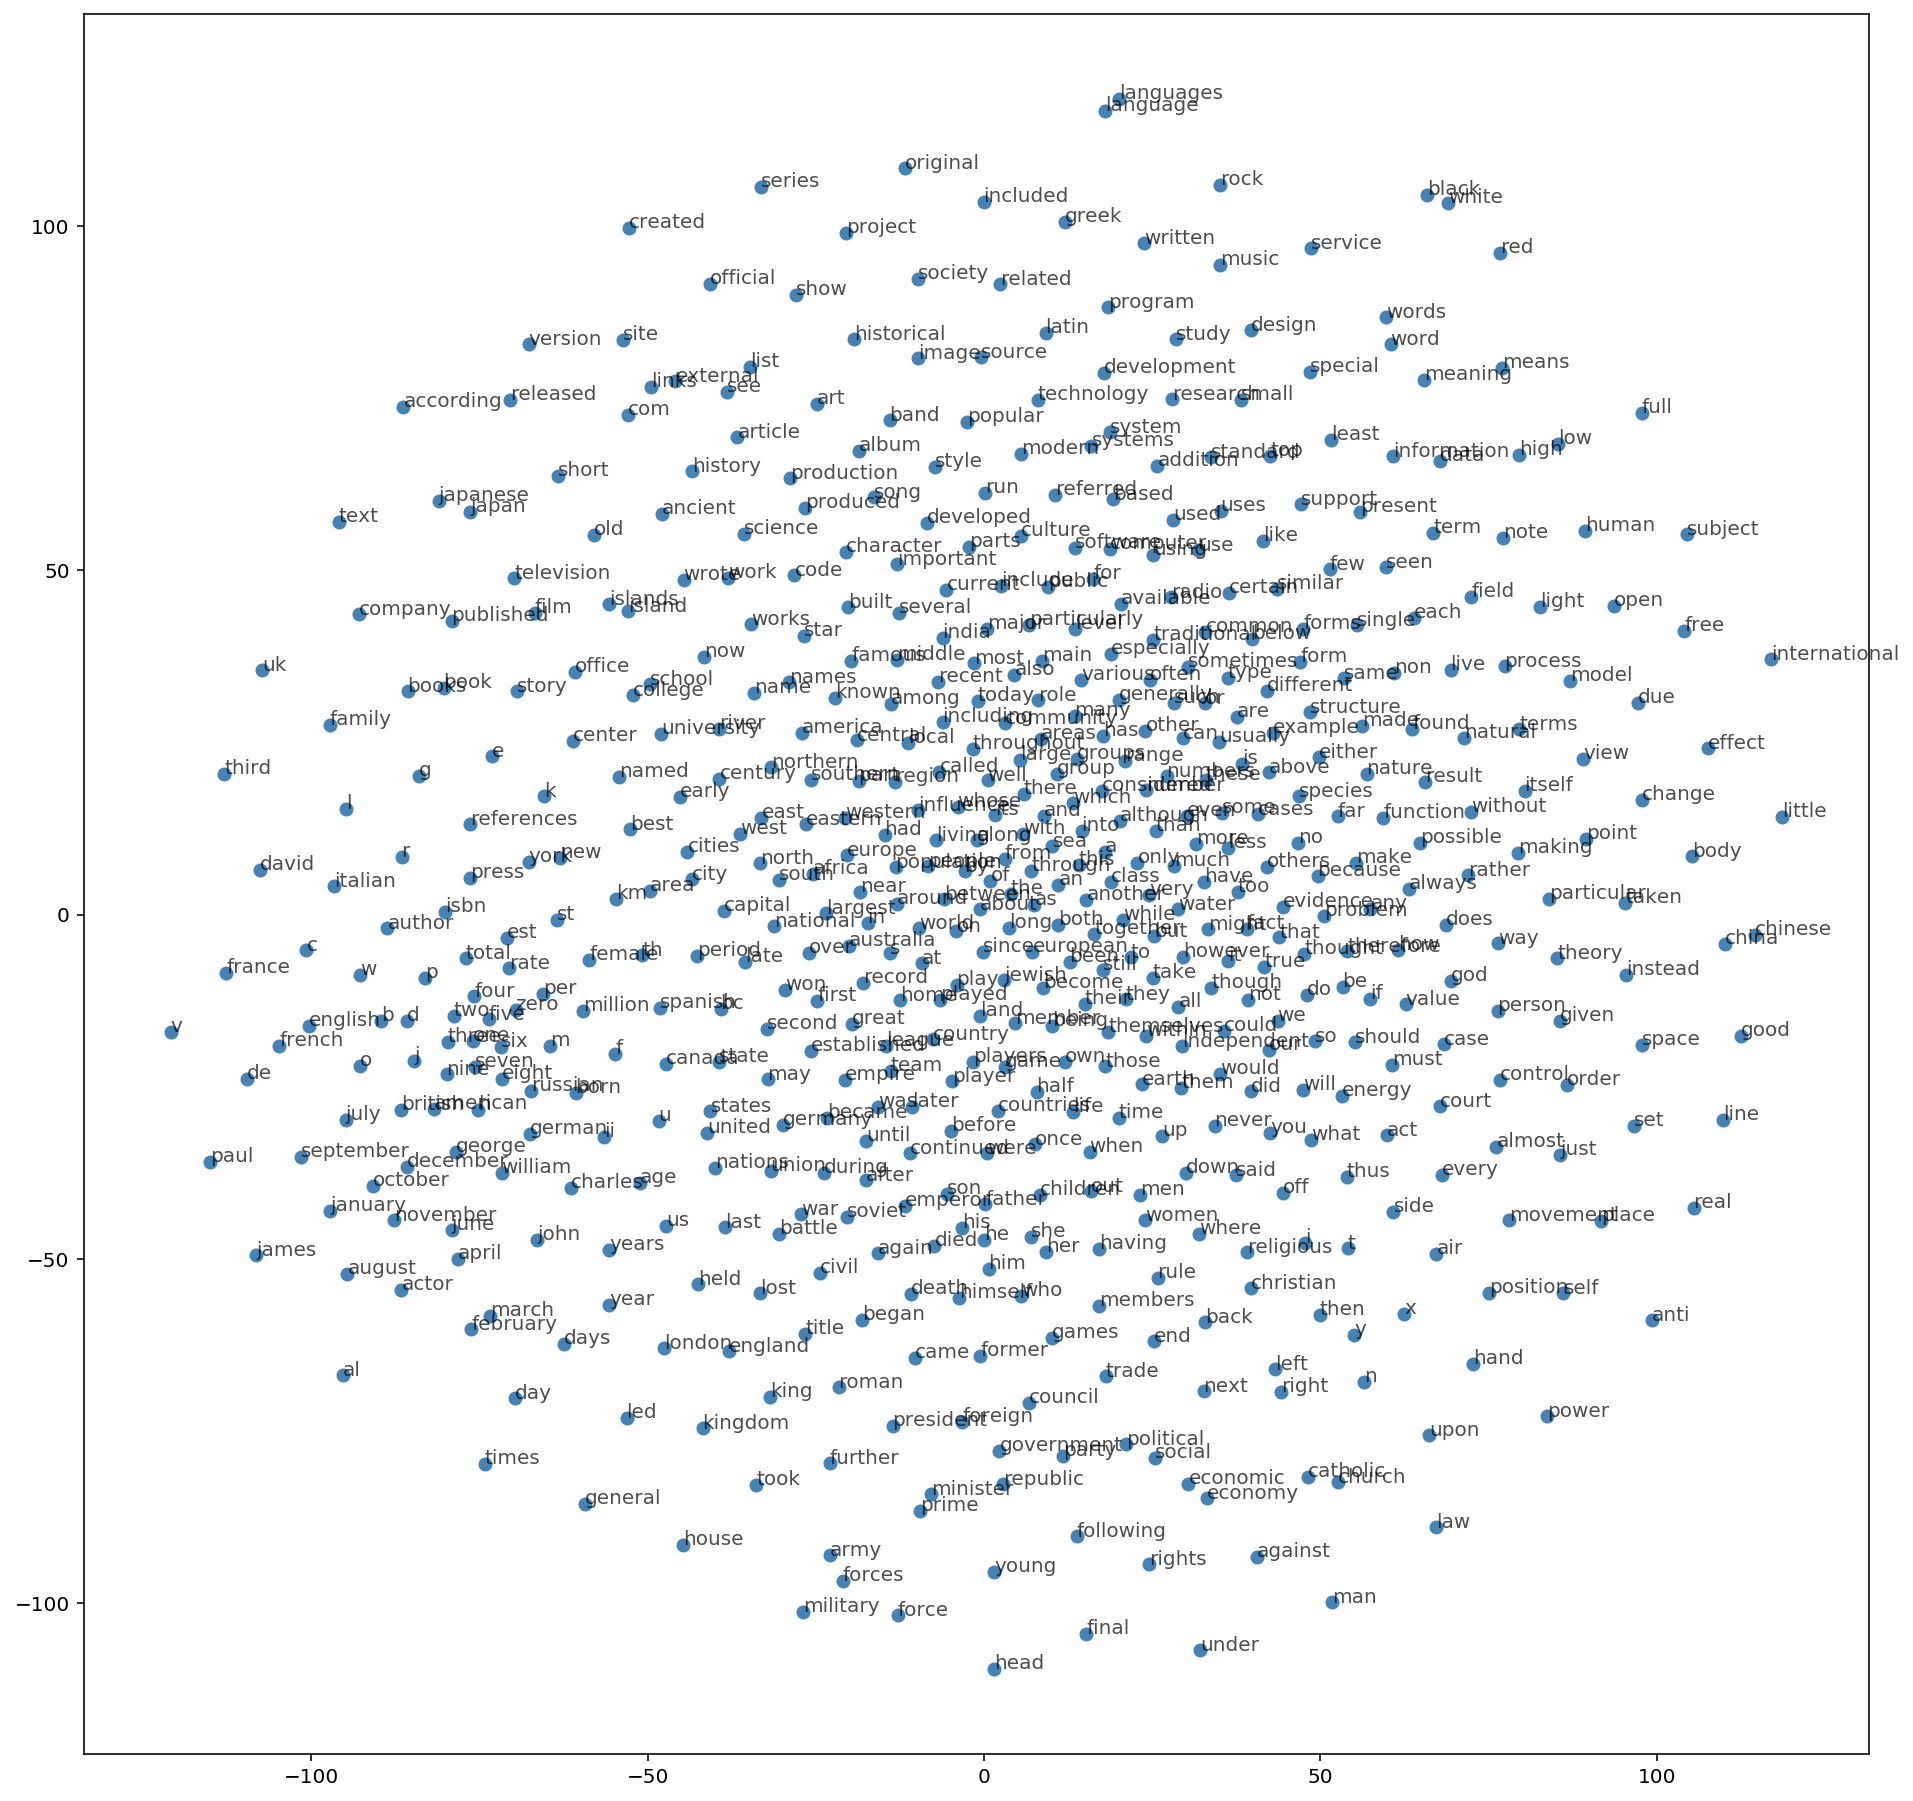

In [23]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)